✅ transactions.csv created!
First 5 rows of transactions data:
  customer_id order_id order_date  order_value
0        C001    O1001 2023-01-05       120.50
1        C002    O1002 2023-01-07        75.00
2        C001    O1003 2023-02-01        45.99
3        C003    O1004 2023-02-05       130.00
4        C002    O1005 2023-03-10       250.75
XGBoost MAE: 138.59, RMSE: 147.52


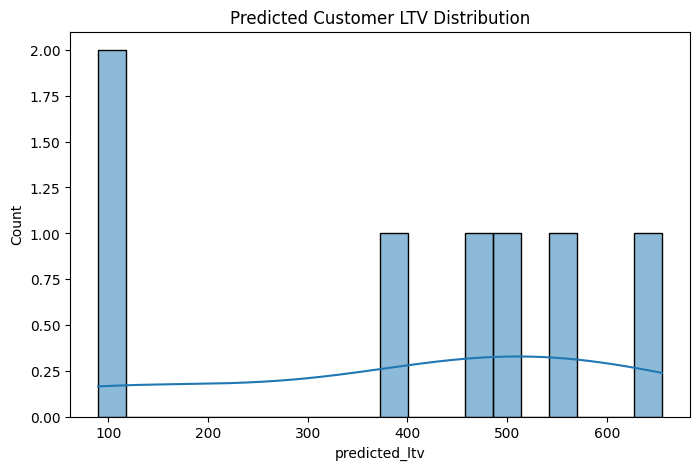

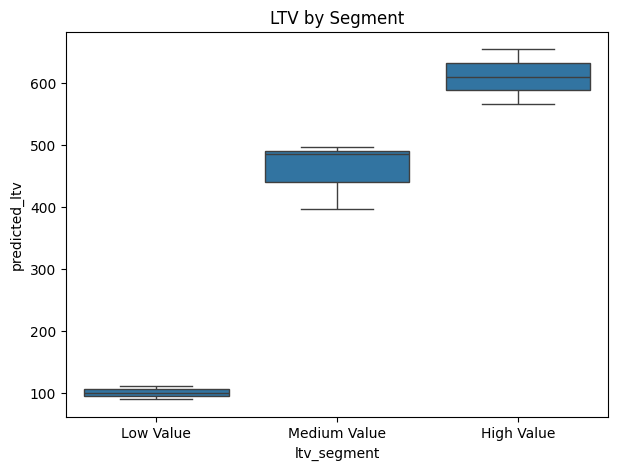

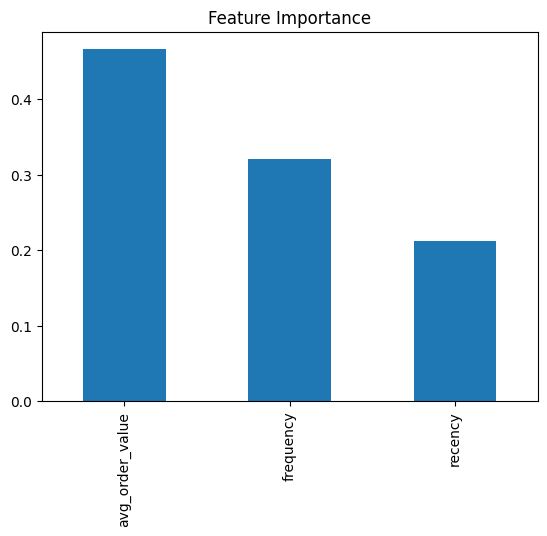

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ customer_ltv_predictions.csv ready for download


In [1]:
# =====================================================
# GOOGLE COLAB: CUSTOMER LIFETIME VALUE (LTV) PREDICTION
# =====================================================

# ------------------ 1. INSTALL ------------------
!pip install xgboost seaborn --quiet

# ------------------ 2. IMPORT LIBRARIES ------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from google.colab import files

# ------------------ 3. CREATE SAMPLE TRANSACTIONS DATA ------------------
csv_text = """customer_id,order_id,order_date,order_value
C001,O1001,2023-01-05,120.50
C002,O1002,2023-01-07,75.00
C001,O1003,2023-02-01,45.99
C003,O1004,2023-02-05,130.00
C002,O1005,2023-03-10,250.75
C004,O1006,2023-03-12,15.00
C001,O1007,2023-04-01,200.00
C005,O1008,2023-04-08,340.00
C003,O1009,2023-04-15,180.25
C002,O1010,2023-05-01,90.50
C006,O1011,2023-05-03,50.00
C004,O1012,2023-05-20,75.25
C005,O1013,2023-06-02,220.00
C006,O1014,2023-06-10,60.00
C007,O1015,2023-06-15,400.00
C007,O1016,2023-07-01,85.00
C002,O1017,2023-07-05,150.00
C001,O1018,2023-07-10,130.00
C005,O1019,2023-08-01,95.75
C003,O1020,2023-08-07,85.50
"""

with open("transactions.csv", "w") as f:
    f.write(csv_text)

print("✅ transactions.csv created!")

# ------------------ 4. LOAD DATA ------------------
data = pd.read_csv("transactions.csv")
data["order_date"] = pd.to_datetime(data["order_date"])
print("First 5 rows of transactions data:")
print(data.head())

# ------------------ 5. FEATURE ENGINEERING ------------------
snapshot_date = data["order_date"].max() + pd.Timedelta(days=1)

ltv_df = (
    data.groupby("customer_id")
    .agg(
        frequency=("order_id", "nunique"),
        total_spend=("order_value", "sum"),
        avg_order_value=("order_value", "mean"),
        recency=("order_date", lambda x: (snapshot_date - x.max()).days)
    )
    .reset_index()
)

# Target variable (simple LTV)
ltv_df["ltv"] = ltv_df["total_spend"]

# ------------------ 6. TRAINING DATA ------------------
X = ltv_df[["frequency", "avg_order_value", "recency"]]
y = ltv_df["ltv"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# ------------------ 7. MODEL TRAINING: XGBOOST ------------------
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"XGBoost MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# ------------------ 8. FINAL MODEL ON FULL DATA ------------------
xgb.fit(X_scaled, y)
ltv_df["predicted_ltv"] = xgb.predict(X_scaled)

# ------------------ 9. CUSTOMER SEGMENTATION ------------------
ltv_df["ltv_segment"] = pd.qcut(
    ltv_df["predicted_ltv"],
    q=3,
    labels=["Low Value", "Medium Value", "High Value"]
)

# ------------------ 10. VISUALIZATIONS ------------------
plt.figure(figsize=(8,5))
sns.histplot(ltv_df["predicted_ltv"], bins=20, kde=True)
plt.title("Predicted Customer LTV Distribution")
plt.show()

plt.figure(figsize=(7,5))
sns.boxplot(data=ltv_df, x="ltv_segment", y="predicted_ltv")
plt.title("LTV by Segment")
plt.show()

# Feature Importance
importance = pd.Series(
    xgb.feature_importances_,
    index=["frequency", "avg_order_value", "recency"]
).sort_values(ascending=False)
importance.plot(kind="bar", title="Feature Importance")
plt.show()

# ------------------ 11. EXPORT CSV ------------------
ltv_df.to_csv("customer_ltv_predictions.csv", index=False)
files.download("customer_ltv_predictions.csv")
print("✅ customer_ltv_predictions.csv ready for download")

